# Contagion simulation

After seeing a lot of really bad statistical analysis of how the Wuhan coronavirus could spread, I decided to build a simple agent-based model to simulate how a disease could break out in a model setting.

## Our model setting

In our model, the world is broken up into 10 clusters ("countries") of varying size, with the only constraint being that China has a relatively large population and that China is the only source of animal-to-human transmission.

## Rules

In each step of the simulation, there is a small chance of animal-to-human transmission.

Next, there is a chance of transmission inside the cluster -- sick people infecting others when going about day-to-day life.

And finally, there is the chance that one of those sick people travels, and infects people in another cluster. This is the only way (in our model) that the virus can make its way to countries besides China.

After a patient is infected, they are contagious for some amount of time before containment, at which point they can't infect anyone else. After some amount of time in containment, they either die or recover and become immune; in either case, they can no longer become sick, nor can they infect others.

(All the time durations and transmission probabilities used are laid out in the "Constants" section below.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

These are the key constants used to run the simulation. Playing with these parameters can give you a sense of how different scenarios could play out -- a higher mortality rate, a higher rate of spread or transmission probability, different containment strategies and incubation periods, and so on.

In [2]:
ANIMAL_2H_RATE = 0.0005
R_0_PRIME = 0.4
SOURCE_CLUSTERS = [0]
TRAVEL_PROB = 0.03
RESPONSE_RATE = 5
CLUSTER_NAMES = ["China", "Japan", "U.S.A", "Canada", "France", "Germany", "Thailand", "U.K.", "Belgium", "Italy", "S. Korea", "Russia", "Vietnam"]
TIME_ALIVE = 10
MORTALITY_RATE = 0.15
N_SIM_STEPS = 100

## Simulation code

Next we have the code for our simulation: each individual host and cluster is represented by an object, and the "universe" contains many such clusters.

In [3]:
class Host:
    def __init__(self, cluster):
        self.infected = False
        self.contained = False
        self.cluster = cluster
        self.infected_at = None
        self.deceased = False
        self.immune = False
    def infect(self, t):
        self.infected = True
        self.infected_at = t
    def contain(self):
        self.contained = True
    def is_immune(self, d):
        self.is_deceased(d)
        return self.immune
    def is_infected(self, d):
        return self.infected
    def is_contagious(self, d):
        return self.is_sick(d) and (not self.is_contained(d))
    def is_sick(self, d):
        return self.infected and (not (self.is_immune(d) or self.is_deceased(d)))
    def is_deceased(self, as_of):
        if self.infected and (not self.deceased) and (not self.immune):
            if (as_of - self.infected_at) >= (RESPONSE_RATE+TIME_ALIVE):
                if np.random.random() < MORTALITY_RATE:
                    self.deceased = True
                else:
                    self.immune = True
        return self.deceased
    def is_contained(self, as_of):
        if self.infected:
            if (as_of - self.infected_at) >= RESPONSE_RATE:
                self.contained = True
        return self.contained
    def reproduction_likelihood(self, x, on):
        isc = self.is_contained(on) or self.is_deceased(on) or self.is_immune(on)
        xsc = x.is_contained(on) or x.is_deceased(on) or x.is_immune(on)
        if isc or xsc:
            return 0.0 # no transmission possible
        if self.cluster == x.cluster:
            return 0.1
        else:
            return 0.05

class HostCluster:
    def __init__(self, idno):
        self.members = []
        self.idno = idno
    def add_host(self, h):
        self.members.append(h)
    def num_infected(self, d):
        return len([x for x in self.members if x.is_infected(d)])
    def num_contained(self, as_of):
        return len([x for x in self.members if x.is_contained(as_of)])
    def num_deceased(self, as_of):
        return len([x for x in self.members if x.is_deceased(as_of)])
    def num_immune(self, as_of):
        return len([x for x in self.members if x.is_immune(as_of)])
    def num_sick(self, as_of):
        return len([x for x in self.members if x.is_sick(as_of)])
    def __eq__(self, o):
        return self.idno == o.idno
    def __str__(self):
        return "Cluster " + str(self.idno)

def rpad(s, minlen=12):
    if len(s) >= minlen:
        return s
    else:
        ns = minlen - len(s)
        ss = " " * ns
        return s + ss

class HostUniverse:
    def __init__(self):
        self.clusters = []
        self.step_id = 0
    def add_cluster(self, c):
        self.clusters.append(c)
    def print_state(self):
        print("Day %d" % (self.step_id,))
        for c in self.clusters:
            n = rpad(CLUSTER_NAMES[c.idno])
            print("%s\t%d / %d infected (%d sick, %d contained, %d deceased, %d recovered)" % (n, c.num_infected(self.step_id), len(c.members), c.num_sick(self.step_id), c.num_contained(self.step_id), c.num_deceased(self.step_id), c.num_immune(self.step_id)))
        print("-----")
    def simulate_step(self):
        self._simulate_animal2h()
        self._simulate_intracluster_h2h()
        self._simulate_intercluster()
        self.step_id += 1
        return self.total_infected()
    def _simulate_animal2h(self):
        for c in self.clusters:
            if not (c.idno in SOURCE_CLUSTERS):
                continue
            for m in c.members:
                if np.random.random() < ANIMAL_2H_RATE:
                    m.infect(self.step_id)
    def _simulate_intracluster_h2h(self,scale=R_0_PRIME):
        for c in self.clusters:
            for i in range(len(c.members)-1):
                m = c.members[i]
                if not m.is_contagious(self.step_id):
                    continue
                m0 = int(np.random.exponential(scale=scale))
                contacts = np.random.choice(c.members, m0, True)
                for contact in contacts:
                    p = contact.reproduction_likelihood(m, self.step_id)
                    if np.random.random() < p:
                        contact.infect(self.step_id)
    def _simulate_intercluster(self):
        for c in self.clusters:
            for m in c.members:
                if (not m.is_contagious(self.step_id)) or (np.random.random() < (1.0-TRAVEL_PROB)):
                    continue
                x_cont = np.random.choice(self.clusters, 1)[0]
                xxs = 0
                for x in x_cont.members:
                    p = x.reproduction_likelihood(m, self.step_id)
                    npr = np.random.random()
                    if npr < p:
                        x.infect(self.step_id)
                        xxs += 1
                    else:
                        pass
                #print("X-contaminations: %d" % xxs)
    def total_infected(self):
        ct = 0
        for c in self.clusters:
            for m in c.members:
                if m.is_infected(self.step_id):
                    ct += 1
        return ct
    def total_deceased(self):
        ct = 0
        for c in self.clusters:
            for m in c.members:
                if m.is_deceased(self.step_id):
                    ct += 1
        return ct
    def total_immune(self):
        ct = 0
        for c in self.clusters:
            for m in c.members:
                if m.is_immune(self.step_id):
                    ct += 1
        return ct
    def total_sick(self):
        ct = 0
        for c in self.clusters:
            for m in c.members:
                if m.is_sick(self.step_id):
                    ct += 1
        return ct
    def total_population(self):
        return sum(len(x.members) for x in self.clusters)

### Utility functions

These aren't particularly important.

In [4]:
def random_cluster(idno,n=100):
    hc = HostCluster(idno)
    for i in range(n):
        hc.add_host(Host(hc))
    return hc

def random_universe(n=10,scale=100):
    u = HostUniverse()
    for i in range(n):
        m = int(np.random.exponential(scale=scale))
        c = random_cluster(i, m)
        u.add_cluster(c)
    return u

def random_universe_with_big_china(n=10,scale=100):
    u = HostUniverse()
    for i in range(n):
        m = int(np.random.exponential(scale=scale)) if i > 0 else 400
        c = random_cluster(i, m)
        u.add_cluster(c)
    return u

## Running the model

We run the model with the "Big China" constraint. We generate 10 "countries" with an average of 100 citizens each (except China, which always has 400). We then run the model for `N_SIM_STEPS` days (50 in our case) and capture the percentage of the population that has been infected, is actively sick, and has died from the virus.

Print outs for each day show breakdowns of patient cases.

You will notice that the first few days usually have no cases at all -- this is the time period where animal-to-human transmission hasn't yet occurred.

In [5]:
u=random_universe_with_big_china(10,100)
dat = []
sick_dat = []
death_dat = []
for i in range(N_SIM_STEPS*2):
    inf = u.simulate_step()
    pop = u.total_population()
    u.print_state()
    ts = u.total_sick()
    td = u.total_deceased()
    sick_dat.append(float(ts)/pop)
    death_dat.append(float(td)/pop)
    dat.append(float(inf)/pop)

Day 1
China       	0 / 400 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Japan       	0 / 62 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.S.A       	0 / 143 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Canada      	0 / 2 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
France      	0 / 52 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Germany     	0 / 266 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Thailand    	0 / 266 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.K.        	0 / 77 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Belgium     	0 / 17 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Italy       	0 / 56 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
-----
Day 2
China       	2 / 400 infected (2 sick, 0 contained, 0 deceased, 0 recovered)
Japan       	0 / 62 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.S.A       	0 / 143 infected (0 sick, 0 contained, 0 deceased, 0 

-----
Day 82
China       	30 / 400 infected (7 sick, 28 contained, 0 deceased, 23 recovered)
Japan       	3 / 62 infected (3 sick, 3 contained, 0 deceased, 0 recovered)
U.S.A       	5 / 143 infected (0 sick, 5 contained, 0 deceased, 5 recovered)
Canada      	1 / 2 infected (1 sick, 0 contained, 0 deceased, 0 recovered)
France      	0 / 52 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Germany     	0 / 266 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Thailand    	0 / 266 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.K.        	0 / 77 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Belgium     	1 / 17 infected (0 sick, 1 contained, 0 deceased, 1 recovered)
Italy       	3 / 56 infected (0 sick, 3 contained, 0 deceased, 3 recovered)
-----
Day 83
China       	30 / 400 infected (7 sick, 29 contained, 0 deceased, 23 recovered)
Japan       	3 / 62 infected (3 sick, 3 contained, 0 deceased, 0 recovered)
U.S.A       	5 / 143 infected (0 sick, 5 contained, 

## Plotting the result on a chart

Finally, we plot our results on a chart. Since all three time series are percentages of the population, a single axis can be used.

What is clear is that the number of affected people will reach a steady state at which point there is more recovery and/or death than new cases, and the growth peters out. You can see that by the end of this simulation the percentage of the population actively sick gets back to zero, although about 1% of the population died.

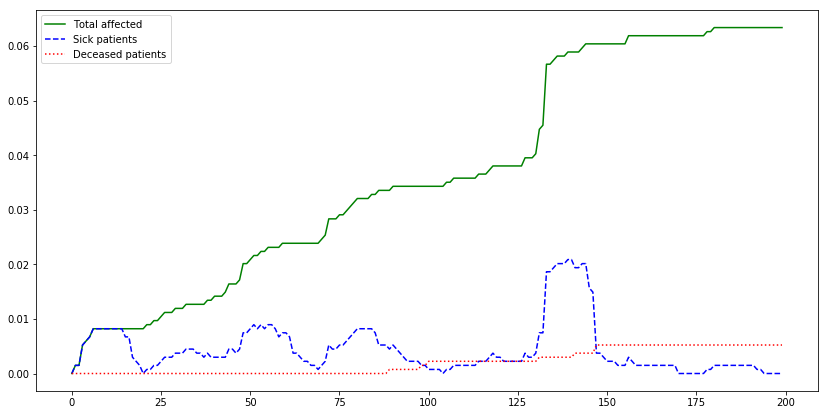

In [6]:
fig, ax = plt.subplots(figsize=(14,7))
xs = list(range(len(dat)))
ax.plot(xs, dat, '-g', label='Total affected')
ax.plot(xs, sick_dat, '--b', label='Sick patients')
ax.plot(xs, death_dat, ':r', label='Deceased patients')
leg = ax.legend()

## Fatalities

The final thing to check would be, once we reach a steady state, what percentage of the human population has died?

In [7]:
dr = int(100*(death_dat[-1]))
print("%s%% of the popultaion is dead after %d days." % (dr, N_SIM_STEPS))

0% of the popultaion is dead after 100 days.


# Conclusions

This has been a fascinating model to study. What is imminently clear is that containment of the virus within borders is legitimately the only way to avoid the entire world population getting the virus at some point or another. With sufficient containment -- and based on the current characteristics of the virus -- it likely will saturate China and eventually be contained before saturating every country in the world.

The general pattern, depending on the parameters you use, is that a certain percentage of the population is infected before containment measures start to decrease the total number of contagious people until it gets back to zero. The key question is, how many people across the world need to get sick before the curve turns around. In some parameterizations, the entire population is affected.

If you change some of these parameters -- transmission likelihood, travel probability, or even time before seeing a doctor -- the outcome can be very different. The curve can become a simple exponential growth until the whole population of earth has been affected. It can reach some maximum and then start dying out. It can never reach the human population at all. Looking at the range of possibilities within reasonable parameters can give you a sense of what _might_ happen.

**Most importantly**, if you change the `TRAVEL_PROBABILITY` variable to be higher, the percent of the world affected by the time a steady state is reached is substantially higher, possibly even reaching 100%.

For example, compare the difference between this curve -- where the probability is increased to 10% -- and you'll see it is a basic exponential growth pattern. **Critically, it only reaches a steady state when the entire world has been affected; there is no containment in this scenario.**

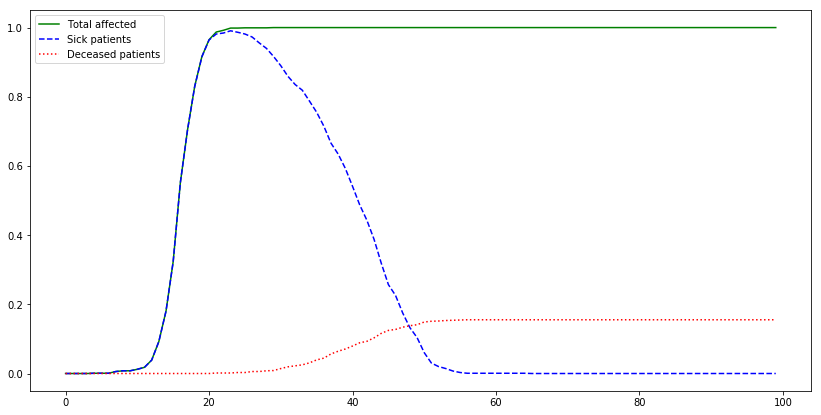

In [8]:
TRAVEL_PROB = 0.1
u=random_universe_with_big_china(10,100)
dat = []
sick_dat = []
death_dat = []
for i in range(N_SIM_STEPS):
    inf = u.simulate_step()
    pop = u.total_population()
    ts = u.total_sick()
    td = u.total_deceased()
    sick_dat.append(float(ts)/pop)
    death_dat.append(float(td)/pop)
    dat.append(float(inf)/pop)
fig, ax = plt.subplots(figsize=(14,7))
xs = list(range(len(dat)))
ax.plot(xs, dat, '-g', label='Total affected')
ax.plot(xs, sick_dat, '--b', label='Sick patients')
ax.plot(xs, death_dat, ':r', label='Deceased patients')
leg = ax.legend()

One key thing this doesn't take into account is the fact that if 50% of the population in a given cluster is sick, the healthcare infrastructure will start to break down, effectively increasing the reproductive possibilities and preventing the containment that is so critical. In a subsequent version of the model, we will also simulate the status of hospitals in each region and the effect that limited beds would have on the course of the epidemic.

## Disclaimer

I wrote up this model in a few minutes due to my own intellectual curiosity. I am not an expert on infectious disease by any stretch, but have spent quite a bit of my life doing this kind of modeling work, so thought I'd give it a try. I haven't had the chance to test everything thoroughly, so there may be bugs.

# Appendix A: The full printout for 10% travel probability

Day 1
China       	0 / 400 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Japan       	0 / 289 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.S.A       	0 / 31 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Canada      	0 / 66 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
France      	0 / 25 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Germany     	0 / 26 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Thailand    	0 / 35 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.K.        	0 / 46 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Belgium     	0 / 88 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Italy       	0 / 3 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
-----
Day 2
China       	0 / 400 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Japan       	0 / 289 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.S.A       	0 / 31 infected (0 sick, 0 contained, 0 deceased, 0 re

Japan       	0 / 289 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.S.A       	0 / 31 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Canada      	0 / 66 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
France      	0 / 25 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Germany     	0 / 26 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Thailand    	0 / 35 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.K.        	0 / 46 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Belgium     	0 / 88 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Italy       	0 / 3 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
-----
Day 15
China       	0 / 400 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Japan       	0 / 289 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.S.A       	0 / 31 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Canada      	0 / 66 infected (0 sick, 0 contained, 0 deceased, 0 recovere

France      	1 / 25 infected (1 sick, 0 contained, 0 deceased, 0 recovered)
Germany     	0 / 26 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Thailand    	0 / 35 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.K.        	0 / 46 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Belgium     	0 / 88 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Italy       	0 / 3 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
-----
Day 38
China       	2 / 400 infected (1 sick, 2 contained, 1 deceased, 0 recovered)
Japan       	0 / 289 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
U.S.A       	0 / 31 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Canada      	0 / 66 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
France      	1 / 25 infected (1 sick, 1 contained, 0 deceased, 0 recovered)
Germany     	0 / 26 infected (0 sick, 0 contained, 0 deceased, 0 recovered)
Thailand    	0 / 35 infected (0 sick, 0 contained, 0 deceased, 0 recovered

U.K.        	41 / 46 infected (41 sick, 5 contained, 0 deceased, 0 recovered)
Belgium     	69 / 88 infected (69 sick, 3 contained, 0 deceased, 0 recovered)
Italy       	2 / 3 infected (2 sick, 0 contained, 0 deceased, 0 recovered)
-----
Day 49
China       	385 / 400 infected (383 sick, 67 contained, 2 deceased, 0 recovered)
Japan       	279 / 289 infected (279 sick, 67 contained, 0 deceased, 0 recovered)
U.S.A       	26 / 31 infected (26 sick, 4 contained, 0 deceased, 0 recovered)
Canada      	56 / 66 infected (56 sick, 20 contained, 0 deceased, 0 recovered)
France      	23 / 25 infected (22 sick, 4 contained, 0 deceased, 1 recovered)
Germany     	25 / 26 infected (25 sick, 7 contained, 0 deceased, 0 recovered)
Thailand    	35 / 35 infected (35 sick, 7 contained, 0 deceased, 0 recovered)
U.K.        	41 / 46 infected (41 sick, 8 contained, 0 deceased, 0 recovered)
Belgium     	79 / 88 infected (79 sick, 9 contained, 0 deceased, 0 recovered)
Italy       	2 / 3 infected (2 sick, 0 contai

Italy       	3 / 3 infected (3 sick, 3 contained, 0 deceased, 0 recovered)
-----
Day 64
China       	400 / 400 infected (239 sick, 385 contained, 30 deceased, 131 recovered)
Japan       	289 / 289 infected (148 sick, 284 contained, 15 deceased, 126 recovered)
U.S.A       	31 / 31 infected (18 sick, 30 contained, 0 deceased, 13 recovered)
Canada      	66 / 66 infected (29 sick, 66 contained, 7 deceased, 30 recovered)
France      	25 / 25 infected (13 sick, 23 contained, 1 deceased, 11 recovered)
Germany     	26 / 26 infected (10 sick, 26 contained, 3 deceased, 13 recovered)
Thailand    	35 / 35 infected (19 sick, 35 contained, 1 deceased, 15 recovered)
U.K.        	45 / 46 infected (24 sick, 45 contained, 4 deceased, 17 recovered)
Belgium     	87 / 88 infected (44 sick, 84 contained, 9 deceased, 34 recovered)
Italy       	3 / 3 infected (2 sick, 3 contained, 0 deceased, 1 recovered)
-----
Day 65
China       	400 / 400 infected (219 sick, 395 contained, 35 deceased, 146 recovered)
Japan 

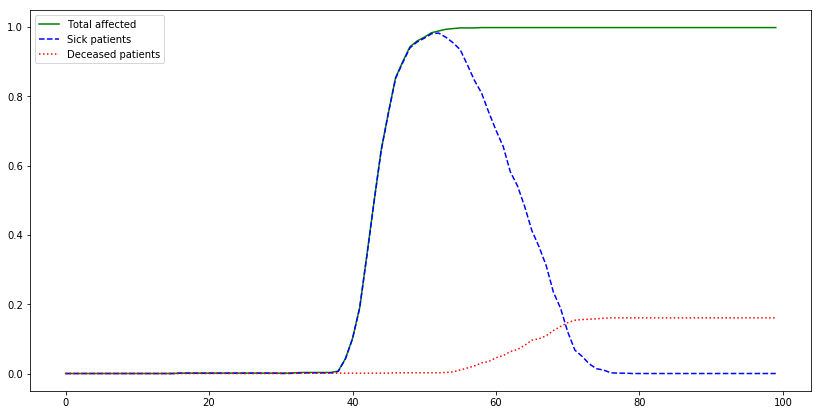

In [9]:
TRAVEL_PROB = 0.1
u=random_universe_with_big_china(10,100)
dat = []
sick_dat = []
death_dat = []
for i in range(N_SIM_STEPS):
    inf = u.simulate_step()
    pop = u.total_population()
    u.print_state()
    ts = u.total_sick()
    td = u.total_deceased()
    sick_dat.append(float(ts)/pop)
    death_dat.append(float(td)/pop)
    dat.append(float(inf)/pop)
dr = int(100*(death_dat[-1]))
print("%s%% of the popultaion is dead after %d days." % (dr, N_SIM_STEPS))
fig, ax = plt.subplots(figsize=(14,7))
xs = list(range(len(dat)))
ax.plot(xs, dat, '-g', label='Total affected')
ax.plot(xs, sick_dat, '--b', label='Sick patients')
ax.plot(xs, death_dat, ':r', label='Deceased patients')
leg = ax.legend()